# Low-Dimensional Representation Using Autoencoder

## Getting the Data

In [1]:
import warnings
warnings.filterwarnings("ignore")
import sys
from herdingspikes.hs2 import HSDetection
from herdingspikes.probe import NeuroPixel
import matplotlib.pyplot as plt
import h5py
import numpy as np

np.random.seed(0)

In [2]:
import urllib.request
file_url = 'http://data.cortexlab.net/singlePhase3/data/rawDataSample.bin'
file_name = "rawDataSample.bin"

urllib.request.urlretrieve(file_url, file_name)

# raw data file (as downloaded above)
data_path = "rawDataSample.bin"

In [3]:
# detection parameters
to_localize = False
cutout_start = 6
cutout_end = 30
threshold = 22
file_directory = 'results/'
file_name = 'ProcessedSpikesNeuropixel'

In [4]:
Probe = NeuroPixel(data_path)
H = HSDetection(Probe, to_localize, cutout_start, cutout_end, threshold,
                maa=0, maxsl=12, minsl=3, ahpthr=0, out_file_name=file_name, 
                file_directory_name=file_directory, save_all=True)

## Detecting Spikes

In [5]:
H.DetectFromRaw()

# Sampling rate: 30000
# Localization Off
# Not Masking any Channels
# Writing out extended detection info
# Number of recorded channels: 385
# Analysing frames: 1800000, Seconds:60.0
# Frames before spike in cutout: 30
# Frames after spike in cutout: 66
# tcuts: 42 55
# tInc: 50000
# Analysing 50000 frames; from -42 to 50055
# Analysing 50000 frames; from 49958 to 100055
# Analysing 50000 frames; from 99958 to 150055
# Analysing 50000 frames; from 149958 to 200055
# Analysing 50000 frames; from 199958 to 250055
# Analysing 50000 frames; from 249958 to 300055
# Analysing 50000 frames; from 299958 to 350055
# Analysing 50000 frames; from 349958 to 400055
# Analysing 50000 frames; from 399958 to 450055
# Analysing 50000 frames; from 449958 to 500055
# Analysing 50000 frames; from 499958 to 550055
# Analysing 50000 frames; from 549958 to 600055
# Analysing 50000 frames; from 599958 to 650055
# Analysing 50000 frames; from 649958 to 700055
# Analysing 50000 frames; from 699958 to 750055
# 

In [6]:
H.LoadDetected()

Detected and read 112625 spikes.


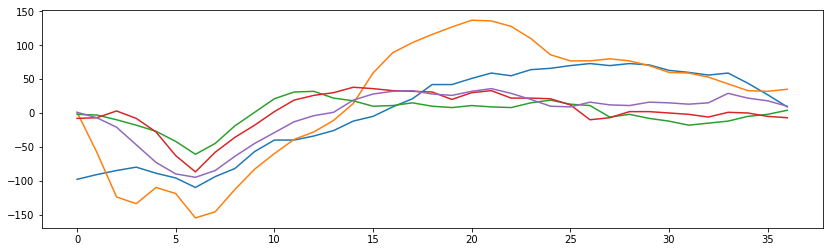

In [7]:
from matplotlib import pyplot as plt
%matplotlib inline

plt.figure(figsize=(14,4))
for i in [14, 18, 77, 90, 156]:
    plt.plot(H.spikes['Shape'][i])
plt.show()
    

In [8]:
length = H.spikes['Shape'][0].shape[0]
total_sigs = H.spikes['Shape'].shape[0]
embedding_size = (int)(length//4)

electrode_data = np.zeros([total_sigs, length])
list_of_sigs = np.random.choice(total_sigs, total_sigs, replace=False)

for i in list_of_sigs:
    electrode_data[i, :] = H.spikes['Shape'][i]
print(electrode_data.shape)

(112625, 37)


## Scaling data between 0 and 1

In [9]:
# electrode_data = electrode_data_temp[:, :]

In [10]:
# max_val = np.amax(electrode_data)
# min_val = np.amin(electrode_data)
# span = max_val - min_val
# electrode_data = (electrode_data - min_val)/span

In [11]:
print(electrode_data)

[[ -8.   0.   3. ... -25. -37. -45.]
 [  7.   4.  17. ...  11.   2.   5.]
 [  4.  -6.  -9. ...  13.  11.  13.]
 ...
 [  0.  -3.  -3. ...   1.   1.   0.]
 [  6.   3.  -4. ...   7.   6.   5.]
 [-24. -32. -29. ...  21.  18.  13.]]


## Designing the AutoEncoder 

In [12]:
import torch
import torch.nn as nn
from torch.autograd import Variable
from torch.utils import data

torch.cuda.set_device(1)
torch.manual_seed(0)

In [13]:
class autoencoder(nn.Module):
    def __init__(self, input_size, embedding_size):
        super(autoencoder, self).__init__()
        activation_layer = nn.PReLU()
        self.encoder = nn.Sequential(nn.Linear(input_size, 100),
                                     activation_layer,
                                     nn.Linear(100, 50),
                                     activation_layer,
                                     nn.Linear(50, 25),
                                     activation_layer,
                                     nn.Linear(25, 80),
                                     activation_layer,
                                     nn.Linear(80, 28),
                                     activation_layer,
                                     nn.Linear(28, embedding_size))
        self.decoder = nn.Sequential(nn.Linear(embedding_size, 16),
                                     activation_layer,
                                     nn.Linear(16, 25),
                                     activation_layer,
                                     nn.Linear(25, input_size))
    
    def forward(self, x):
        enc = self.encoder(x)
        dec = self.decoder(enc)
        return enc, dec

## Splitting the data into Train and Test

In [14]:
train_lim = int(0.8*electrode_data.shape[0])
electrode_data_train = electrode_data[:train_lim, :]
electrode_data_test = electrode_data[train_lim:, :]

print("Training Datasize:", electrode_data_train.shape)
print("Test Datasize:", electrode_data_test.shape)

Training Datasize: (90100, 37)
Test Datasize: (22525, 37)


In [15]:
import random
random.seed(0)

def train_ae(model, input_data, criterion, optimizer, epoch_range,  batch_size):
    losses = []
    for num_epoch in range(epoch_range):
        selected = random.sample(range(0, input_data.shape[0]), batch_size)
        for feats in selected:
            x = input_data[feats, :]
            x = torch.from_numpy(x).float().cuda()
            #---------FORWARD------------#
            enc, out = model.forward(x)
            out = torch.tensor(out).float().cuda()
            loss = criterion(out, x)
            #---------BACKWARD------------#
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        losses.append(loss.data[0])
        print('epoch [{}/{}], loss:{:.5f}, avg:{:.5f}'.format(num_epoch + 1, epoch_range, 
                                                              loss.data[0], sum(losses[-10:])/len(losses[-10:])))
    return enc, out, losses

In [16]:
def init_weights(layer):
    if type(layer) == nn.Linear:
        nn.init.xavier_normal_(layer.weight)

In [17]:
epoch_range = 5000
batch_size = 150
learning_rate = 0.0001

ae_1 = autoencoder(length, embedding_size).cuda()
ae_1.apply(init_weights)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(
    ae_1.parameters(), lr=learning_rate, weight_decay=0.001)

enc, out, losses = train_ae(ae_1, electrode_data_train, criterion, optimizer, epoch_range, batch_size)

epoch [1/5000], loss:451.00305, avg:451.00305
epoch [2/5000], loss:521.82007, avg:486.41156
epoch [3/5000], loss:210.92551, avg:394.58289
epoch [4/5000], loss:765.53693, avg:487.32141
epoch [5/5000], loss:1141.71252, avg:618.19965
epoch [6/5000], loss:1813.71204, avg:817.45166
epoch [7/5000], loss:80.47611, avg:712.16949
epoch [8/5000], loss:236.49525, avg:652.71014
epoch [9/5000], loss:483.79144, avg:633.94141
epoch [10/5000], loss:466.01477, avg:617.14874
epoch [11/5000], loss:47.28614, avg:576.77704
epoch [12/5000], loss:97.03410, avg:534.29846
epoch [13/5000], loss:100.69640, avg:523.27557
epoch [14/5000], loss:94.54294, avg:456.17618
epoch [15/5000], loss:248.98813, avg:366.90375
epoch [16/5000], loss:42.80944, avg:189.81348
epoch [17/5000], loss:179.16324, avg:199.68219
epoch [18/5000], loss:182.56172, avg:194.28885
epoch [19/5000], loss:126.22441, avg:158.53214
epoch [20/5000], loss:209.45399, avg:132.87605
epoch [21/5000], loss:97.96968, avg:137.94441
epoch [22/5000], loss:40.2

epoch [179/5000], loss:42.80726, avg:48.52400
epoch [180/5000], loss:91.14106, avg:56.32313
epoch [181/5000], loss:40.25037, avg:58.62617
epoch [182/5000], loss:16.91181, avg:56.99454
epoch [183/5000], loss:21.24839, avg:53.04436
epoch [184/5000], loss:10.75089, avg:39.75356
epoch [185/5000], loss:43.37114, avg:38.90428
epoch [186/5000], loss:65.25996, avg:43.24691
epoch [187/5000], loss:67.53471, avg:43.12522
epoch [188/5000], loss:35.87052, avg:43.51461
epoch [189/5000], loss:172.07870, avg:56.44175
epoch [190/5000], loss:11.05039, avg:48.43269
epoch [191/5000], loss:22.70513, avg:46.67816
epoch [192/5000], loss:35.75927, avg:48.56291
epoch [193/5000], loss:199.58521, avg:66.39660
epoch [194/5000], loss:28.92867, avg:68.21437
epoch [195/5000], loss:22.18053, avg:66.09531
epoch [196/5000], loss:38.48613, avg:63.41793
epoch [197/5000], loss:27.01597, avg:59.36605
epoch [198/5000], loss:19.31643, avg:57.71064
epoch [199/5000], loss:52.75200, avg:45.77797
epoch [200/5000], loss:16.29612,

epoch [358/5000], loss:17.84974, avg:32.48712
epoch [359/5000], loss:91.96935, avg:38.57605
epoch [360/5000], loss:11.93634, avg:35.47224
epoch [361/5000], loss:36.99068, avg:33.14158
epoch [362/5000], loss:15.39454, avg:32.26892
epoch [363/5000], loss:27.11004, avg:30.10292
epoch [364/5000], loss:26.83822, avg:30.83004
epoch [365/5000], loss:17.24716, avg:31.05081
epoch [366/5000], loss:22.75762, avg:30.87252
epoch [367/5000], loss:92.17435, avg:36.02681
epoch [368/5000], loss:69.23240, avg:41.16507
epoch [369/5000], loss:13.49477, avg:33.31761
epoch [370/5000], loss:19.62113, avg:34.08609
epoch [371/5000], loss:14.49969, avg:31.83699
epoch [372/5000], loss:29.20969, avg:33.21850
epoch [373/5000], loss:55.82613, avg:36.09012
epoch [374/5000], loss:29.44615, avg:36.35091
epoch [375/5000], loss:22.87913, avg:36.91410
epoch [376/5000], loss:56.08253, avg:40.24659
epoch [377/5000], loss:23.80756, avg:33.40992
epoch [378/5000], loss:25.96839, avg:29.08352
epoch [379/5000], loss:9.35270, av

epoch [537/5000], loss:23.82685, avg:23.50184
epoch [538/5000], loss:16.23987, avg:23.19360
epoch [539/5000], loss:8.53782, avg:18.68468
epoch [540/5000], loss:34.11600, avg:20.19477
epoch [541/5000], loss:26.48615, avg:21.45069
epoch [542/5000], loss:143.07846, avg:31.65547
epoch [543/5000], loss:45.40301, avg:34.76056
epoch [544/5000], loss:12.54377, avg:33.78649
epoch [545/5000], loss:29.55075, avg:36.22292
epoch [546/5000], loss:13.51205, avg:35.32948
epoch [547/5000], loss:16.19491, avg:34.56628
epoch [548/5000], loss:20.86443, avg:35.02874
epoch [549/5000], loss:12.82423, avg:35.45738
epoch [550/5000], loss:44.84703, avg:36.53048
epoch [551/5000], loss:24.89160, avg:36.37103
epoch [552/5000], loss:22.24434, avg:24.28761
epoch [553/5000], loss:96.97723, avg:29.44504
epoch [554/5000], loss:38.23214, avg:32.01387
epoch [555/5000], loss:11.61018, avg:30.21982
epoch [556/5000], loss:81.86716, avg:37.05532
epoch [557/5000], loss:88.33346, avg:44.26918
epoch [558/5000], loss:10.41841, a

epoch [716/5000], loss:32.14829, avg:34.75573
epoch [717/5000], loss:19.21710, avg:35.06186
epoch [718/5000], loss:11.08379, avg:34.10847
epoch [719/5000], loss:9.52256, avg:33.12205
epoch [720/5000], loss:123.61697, avg:43.76270
epoch [721/5000], loss:46.58499, avg:45.96990
epoch [722/5000], loss:8.10275, avg:38.29847
epoch [723/5000], loss:8.69093, avg:33.11090
epoch [724/5000], loss:8.29558, avg:29.78052
epoch [725/5000], loss:37.58221, avg:30.48452
epoch [726/5000], loss:15.02496, avg:28.77219
epoch [727/5000], loss:29.26528, avg:29.77701
epoch [728/5000], loss:17.67421, avg:30.43605
epoch [729/5000], loss:7.16262, avg:30.20006
epoch [730/5000], loss:57.64168, avg:23.60252
epoch [731/5000], loss:36.22388, avg:22.56641
epoch [732/5000], loss:11.37135, avg:22.89327
epoch [733/5000], loss:8.95355, avg:22.91954
epoch [734/5000], loss:18.79084, avg:23.96906
epoch [735/5000], loss:10.98430, avg:21.30927
epoch [736/5000], loss:16.61741, avg:21.46851
epoch [737/5000], loss:23.77997, avg:20

epoch [895/5000], loss:13.65855, avg:17.69662
epoch [896/5000], loss:26.65050, avg:18.28907
epoch [897/5000], loss:13.62625, avg:17.57180
epoch [898/5000], loss:27.83069, avg:19.06105
epoch [899/5000], loss:38.85409, avg:21.18017
epoch [900/5000], loss:31.86556, avg:21.60337
epoch [901/5000], loss:38.13441, avg:23.57934
epoch [902/5000], loss:30.81995, avg:24.53687
epoch [903/5000], loss:127.78532, avg:36.45115
epoch [904/5000], loss:14.56483, avg:36.37901
epoch [905/5000], loss:36.37148, avg:38.65031
epoch [906/5000], loss:43.50859, avg:40.33612
epoch [907/5000], loss:18.49665, avg:40.82316
epoch [908/5000], loss:28.58807, avg:40.89890
epoch [909/5000], loss:39.46220, avg:40.95971
epoch [910/5000], loss:129.23715, avg:50.69687
epoch [911/5000], loss:23.79961, avg:49.26339
epoch [912/5000], loss:30.91379, avg:49.27277
epoch [913/5000], loss:17.92012, avg:38.28625
epoch [914/5000], loss:12.75702, avg:38.10547
epoch [915/5000], loss:53.68574, avg:39.83689
epoch [916/5000], loss:23.22315,

epoch [1072/5000], loss:9.18954, avg:14.54219
epoch [1073/5000], loss:15.32470, avg:14.43223
epoch [1074/5000], loss:52.36195, avg:17.22698
epoch [1075/5000], loss:30.57364, avg:19.39142
epoch [1076/5000], loss:9.37340, avg:19.33175
epoch [1077/5000], loss:25.17066, avg:20.13755
epoch [1078/5000], loss:33.25570, avg:22.57699
epoch [1079/5000], loss:54.66678, avg:25.38987
epoch [1080/5000], loss:19.15993, avg:26.39697
epoch [1081/5000], loss:24.11227, avg:27.31886
epoch [1082/5000], loss:41.75695, avg:30.57560
epoch [1083/5000], loss:46.14927, avg:33.65805
epoch [1084/5000], loss:22.77344, avg:30.69920
epoch [1085/5000], loss:30.04954, avg:30.64679
epoch [1086/5000], loss:12.57264, avg:30.96671
epoch [1087/5000], loss:11.34407, avg:29.58405
epoch [1088/5000], loss:9.63146, avg:27.22164
epoch [1089/5000], loss:24.17700, avg:24.17266
epoch [1090/5000], loss:7.88534, avg:23.04520
epoch [1091/5000], loss:23.81151, avg:23.01512
epoch [1092/5000], loss:19.28181, avg:20.76761
epoch [1093/5000]

epoch [1247/5000], loss:14.84445, avg:26.63002
epoch [1248/5000], loss:45.90342, avg:28.43751
epoch [1249/5000], loss:23.75909, avg:28.99302
epoch [1250/5000], loss:9.63467, avg:25.96165
epoch [1251/5000], loss:15.62049, avg:25.89281
epoch [1252/5000], loss:20.28604, avg:23.47710
epoch [1253/5000], loss:18.61730, avg:20.82236
epoch [1254/5000], loss:18.69724, avg:19.31837
epoch [1255/5000], loss:90.55306, avg:27.02573
epoch [1256/5000], loss:10.32899, avg:26.82448
epoch [1257/5000], loss:90.44659, avg:34.38469
epoch [1258/5000], loss:33.04241, avg:33.09859
epoch [1259/5000], loss:63.14977, avg:37.03766
epoch [1260/5000], loss:25.69270, avg:38.64346
epoch [1261/5000], loss:28.66269, avg:39.94768
epoch [1262/5000], loss:23.88285, avg:40.30736
epoch [1263/5000], loss:15.91071, avg:40.03670
epoch [1264/5000], loss:13.33528, avg:39.50050
epoch [1265/5000], loss:11.57305, avg:31.60250
epoch [1266/5000], loss:12.05152, avg:31.77476
epoch [1267/5000], loss:16.95468, avg:24.42557
epoch [1268/50

epoch [1422/5000], loss:22.67946, avg:30.00077
epoch [1423/5000], loss:8.38408, avg:29.46056
epoch [1424/5000], loss:70.03570, avg:33.18026
epoch [1425/5000], loss:7.66973, avg:32.61926
epoch [1426/5000], loss:21.49734, avg:29.95200
epoch [1427/5000], loss:25.12465, avg:29.63447
epoch [1428/5000], loss:12.26168, avg:27.54688
epoch [1429/5000], loss:18.93134, avg:27.92335
epoch [1430/5000], loss:24.89741, avg:22.10941
epoch [1431/5000], loss:14.92175, avg:22.64031
epoch [1432/5000], loss:5.72678, avg:20.94505
epoch [1433/5000], loss:18.17154, avg:21.92379
epoch [1434/5000], loss:29.51881, avg:17.87210
epoch [1435/5000], loss:13.65297, avg:18.47043
epoch [1436/5000], loss:7.89920, avg:17.11061
epoch [1437/5000], loss:10.91280, avg:15.68943
epoch [1438/5000], loss:52.88386, avg:19.75165
epoch [1439/5000], loss:14.99259, avg:19.35777
epoch [1440/5000], loss:74.90600, avg:24.35863
epoch [1441/5000], loss:8.42501, avg:23.70896
epoch [1442/5000], loss:15.92711, avg:24.72899
epoch [1443/5000],

epoch [1597/5000], loss:19.17097, avg:22.14266
epoch [1598/5000], loss:39.88428, avg:22.01343
epoch [1599/5000], loss:16.81987, avg:22.58346
epoch [1600/5000], loss:9.32324, avg:21.46729
epoch [1601/5000], loss:32.31215, avg:23.51374
epoch [1602/5000], loss:15.38801, avg:21.70349
epoch [1603/5000], loss:12.21259, avg:20.48641
epoch [1604/5000], loss:9.12144, avg:19.41747
epoch [1605/5000], loss:21.73850, avg:19.19220
epoch [1606/5000], loss:14.21151, avg:19.01826
epoch [1607/5000], loss:11.43123, avg:18.24428
epoch [1608/5000], loss:65.20189, avg:20.77604
epoch [1609/5000], loss:89.93511, avg:28.08757
epoch [1610/5000], loss:19.15348, avg:29.07059
epoch [1611/5000], loss:41.77429, avg:30.01681
epoch [1612/5000], loss:21.80823, avg:30.65883
epoch [1613/5000], loss:16.26785, avg:31.06435
epoch [1614/5000], loss:16.57287, avg:31.80950
epoch [1615/5000], loss:12.32747, avg:30.86840
epoch [1616/5000], loss:10.66672, avg:30.51392
epoch [1617/5000], loss:16.74215, avg:31.04501
epoch [1618/500

epoch [1772/5000], loss:15.06943, avg:21.31835
epoch [1773/5000], loss:19.12287, avg:21.57047
epoch [1774/5000], loss:17.08780, avg:21.91935
epoch [1775/5000], loss:9.46577, avg:20.38470
epoch [1776/5000], loss:58.26548, avg:24.55408
epoch [1777/5000], loss:19.17515, avg:24.99733
epoch [1778/5000], loss:9.28402, avg:24.45937
epoch [1779/5000], loss:34.12642, avg:22.30627
epoch [1780/5000], loss:12.24402, avg:21.33740
epoch [1781/5000], loss:45.99298, avg:23.98339
epoch [1782/5000], loss:7.02800, avg:23.17925
epoch [1783/5000], loss:26.36079, avg:23.90304
epoch [1784/5000], loss:39.75548, avg:26.16981
epoch [1785/5000], loss:22.68208, avg:27.49144
epoch [1786/5000], loss:16.49831, avg:23.31473
epoch [1787/5000], loss:36.97508, avg:25.09472
epoch [1788/5000], loss:12.09378, avg:25.37569
epoch [1789/5000], loss:14.67534, avg:23.43059
epoch [1790/5000], loss:23.08724, avg:24.51491
epoch [1791/5000], loss:7.48590, avg:20.66420
epoch [1792/5000], loss:34.69950, avg:23.43135
epoch [1793/5000]

epoch [1947/5000], loss:27.16586, avg:19.51237
epoch [1948/5000], loss:83.71581, avg:26.14251
epoch [1949/5000], loss:9.25922, avg:25.96988
epoch [1950/5000], loss:8.22251, avg:25.61016
epoch [1951/5000], loss:33.42852, avg:27.31566
epoch [1952/5000], loss:37.51302, avg:27.56872
epoch [1953/5000], loss:15.50703, avg:27.09591
epoch [1954/5000], loss:18.23557, avg:27.99835
epoch [1955/5000], loss:18.77113, avg:26.14121
epoch [1956/5000], loss:9.10747, avg:26.09262
epoch [1957/5000], loss:20.36394, avg:25.41242
epoch [1958/5000], loss:8.43752, avg:17.88459
epoch [1959/5000], loss:8.35186, avg:17.79386
epoch [1960/5000], loss:20.65619, avg:19.03722
epoch [1961/5000], loss:41.08586, avg:19.80296
epoch [1962/5000], loss:7.98123, avg:16.84978
epoch [1963/5000], loss:18.71074, avg:17.17015
epoch [1964/5000], loss:40.30938, avg:19.37753
epoch [1965/5000], loss:15.94298, avg:19.09472
epoch [1966/5000], loss:17.74674, avg:19.95865
epoch [1967/5000], loss:12.49593, avg:19.17184
epoch [1968/5000], 

epoch [2122/5000], loss:33.05244, avg:18.75513
epoch [2123/5000], loss:132.94458, avg:30.88713
epoch [2124/5000], loss:46.37237, avg:32.42566
epoch [2125/5000], loss:27.67299, avg:33.71101
epoch [2126/5000], loss:13.71500, avg:33.60746
epoch [2127/5000], loss:36.47451, avg:35.56197
epoch [2128/5000], loss:14.97605, avg:35.17608
epoch [2129/5000], loss:13.95834, avg:35.30036
epoch [2130/5000], loss:46.98747, avg:37.77472
epoch [2131/5000], loss:17.86598, avg:38.40197
epoch [2132/5000], loss:5.75418, avg:35.67215
epoch [2133/5000], loss:93.54100, avg:31.73179
epoch [2134/5000], loss:18.54770, avg:28.94932
epoch [2135/5000], loss:32.50296, avg:29.43232
epoch [2136/5000], loss:11.00913, avg:29.16173
epoch [2137/5000], loss:24.30349, avg:27.94463
epoch [2138/5000], loss:17.39410, avg:28.18644
epoch [2139/5000], loss:11.95921, avg:27.98652
epoch [2140/5000], loss:14.90887, avg:24.77866
epoch [2141/5000], loss:17.05110, avg:24.69717
epoch [2142/5000], loss:25.83186, avg:26.70494
epoch [2143/5

epoch [2297/5000], loss:35.25488, avg:24.72800
epoch [2298/5000], loss:17.75533, avg:23.57269
epoch [2299/5000], loss:22.51500, avg:21.45975
epoch [2300/5000], loss:18.49273, avg:20.03955
epoch [2301/5000], loss:14.22517, avg:18.73736
epoch [2302/5000], loss:10.47827, avg:18.04995
epoch [2303/5000], loss:21.17540, avg:18.80723
epoch [2304/5000], loss:17.64109, avg:17.97202
epoch [2305/5000], loss:13.00856, avg:17.90412
epoch [2306/5000], loss:12.32500, avg:18.28714
epoch [2307/5000], loss:19.78744, avg:16.74040
epoch [2308/5000], loss:11.66531, avg:16.13140
epoch [2309/5000], loss:7.69144, avg:14.64904
epoch [2310/5000], loss:12.91126, avg:14.09089
epoch [2311/5000], loss:13.23003, avg:13.99138
epoch [2312/5000], loss:16.44485, avg:14.58804
epoch [2313/5000], loss:20.00389, avg:14.47089
epoch [2314/5000], loss:94.10541, avg:22.11732
epoch [2315/5000], loss:8.23464, avg:21.63993
epoch [2316/5000], loss:10.95409, avg:21.50284
epoch [2317/5000], loss:19.47170, avg:21.47126
epoch [2318/500

epoch [2472/5000], loss:18.55984, avg:36.84578
epoch [2473/5000], loss:8.92233, avg:28.39244
epoch [2474/5000], loss:57.52007, avg:33.23730
epoch [2475/5000], loss:15.11145, avg:33.10094
epoch [2476/5000], loss:27.32648, avg:33.36232
epoch [2477/5000], loss:37.28720, avg:34.54823
epoch [2478/5000], loss:284.97000, avg:52.73370
epoch [2479/5000], loss:10.83426, avg:51.62930
epoch [2480/5000], loss:12.67278, avg:50.28762
epoch [2481/5000], loss:42.80088, avg:51.60053
epoch [2482/5000], loss:10.62787, avg:50.80733
epoch [2483/5000], loss:19.10645, avg:51.82574
epoch [2484/5000], loss:33.38209, avg:49.41195
epoch [2485/5000], loss:15.27436, avg:49.42823
epoch [2486/5000], loss:10.33362, avg:47.72895
epoch [2487/5000], loss:15.12257, avg:45.51249
epoch [2488/5000], loss:27.54675, avg:19.77016
epoch [2489/5000], loss:21.96814, avg:20.88355
epoch [2490/5000], loss:29.41955, avg:22.55823
epoch [2491/5000], loss:30.45351, avg:21.32349
epoch [2492/5000], loss:45.76252, avg:24.83696
epoch [2493/5

epoch [2647/5000], loss:39.63903, avg:28.35160
epoch [2648/5000], loss:19.81499, avg:29.22435
epoch [2649/5000], loss:18.66852, avg:29.48236
epoch [2650/5000], loss:15.68048, avg:19.25797
epoch [2651/5000], loss:15.87190, avg:19.46147
epoch [2652/5000], loss:6.23539, avg:18.26952
epoch [2653/5000], loss:33.73385, avg:19.65487
epoch [2654/5000], loss:20.63070, avg:20.33776
epoch [2655/5000], loss:7.52904, avg:18.89454
epoch [2656/5000], loss:12.87799, avg:19.06819
epoch [2657/5000], loss:16.29451, avg:16.73374
epoch [2658/5000], loss:14.19156, avg:16.17139
epoch [2659/5000], loss:16.45404, avg:15.94995
epoch [2660/5000], loss:10.97734, avg:15.47963
epoch [2661/5000], loss:134.08995, avg:27.30144
epoch [2662/5000], loss:18.67426, avg:28.54532
epoch [2663/5000], loss:27.49160, avg:27.92110
epoch [2664/5000], loss:19.15021, avg:27.77305
epoch [2665/5000], loss:142.58377, avg:41.27853
epoch [2666/5000], loss:15.30163, avg:41.52089
epoch [2667/5000], loss:31.77147, avg:43.06858
epoch [2668/5

epoch [2822/5000], loss:34.83600, avg:28.30877
epoch [2823/5000], loss:23.61091, avg:26.79502
epoch [2824/5000], loss:17.38704, avg:24.76823
epoch [2825/5000], loss:26.16724, avg:26.40932
epoch [2826/5000], loss:16.84765, avg:26.34279
epoch [2827/5000], loss:17.23888, avg:22.75558
epoch [2828/5000], loss:16.14819, avg:21.57195
epoch [2829/5000], loss:47.02662, avg:23.66606
epoch [2830/5000], loss:16.09212, avg:23.11189
epoch [2831/5000], loss:18.85772, avg:23.42124
epoch [2832/5000], loss:7.29137, avg:20.66677
epoch [2833/5000], loss:14.67916, avg:19.77360
epoch [2834/5000], loss:36.00298, avg:21.63519
epoch [2835/5000], loss:56.27077, avg:24.64555
epoch [2836/5000], loss:33.60526, avg:26.32131
epoch [2837/5000], loss:18.43320, avg:26.44074
epoch [2838/5000], loss:15.24133, avg:26.35005
epoch [2839/5000], loss:30.19215, avg:24.66661
epoch [2840/5000], loss:30.46455, avg:26.10385
epoch [2841/5000], loss:17.07121, avg:25.92520
epoch [2842/5000], loss:60.16393, avg:31.21245
epoch [2843/50

epoch [2997/5000], loss:18.60570, avg:23.82985
epoch [2998/5000], loss:41.97514, avg:26.73872
epoch [2999/5000], loss:33.77558, avg:25.60395
epoch [3000/5000], loss:12.51425, avg:25.37512
epoch [3001/5000], loss:33.97206, avg:25.49272
epoch [3002/5000], loss:38.30415, avg:25.46809
epoch [3003/5000], loss:65.05391, avg:30.44475
epoch [3004/5000], loss:9.90999, avg:29.51148
epoch [3005/5000], loss:51.74869, avg:32.58677
epoch [3006/5000], loss:14.44687, avg:32.03064
epoch [3007/5000], loss:22.56908, avg:32.42697
epoch [3008/5000], loss:10.11119, avg:29.24058
epoch [3009/5000], loss:14.68373, avg:27.33139
epoch [3010/5000], loss:37.59259, avg:29.83922
epoch [3011/5000], loss:13.48011, avg:27.79003
epoch [3012/5000], loss:14.59981, avg:25.41960
epoch [3013/5000], loss:19.25738, avg:20.83994
epoch [3014/5000], loss:37.19723, avg:23.56867
epoch [3015/5000], loss:21.94327, avg:20.58813
epoch [3016/5000], loss:13.31362, avg:20.47480
epoch [3017/5000], loss:51.55301, avg:23.37319
epoch [3018/50

epoch [3172/5000], loss:13.28017, avg:21.86841
epoch [3173/5000], loss:32.89314, avg:22.37104
epoch [3174/5000], loss:16.23543, avg:22.35554
epoch [3175/5000], loss:26.74026, avg:23.44121
epoch [3176/5000], loss:30.15645, avg:23.54988
epoch [3177/5000], loss:20.42628, avg:21.34842
epoch [3178/5000], loss:19.18066, avg:21.79851
epoch [3179/5000], loss:8.23551, avg:21.57710
epoch [3180/5000], loss:25.14544, avg:20.52025
epoch [3181/5000], loss:21.47449, avg:21.37678
epoch [3182/5000], loss:102.30740, avg:30.27950
epoch [3183/5000], loss:14.14365, avg:28.40456
epoch [3184/5000], loss:9.05463, avg:27.68648
epoch [3185/5000], loss:8.35672, avg:25.84812
epoch [3186/5000], loss:14.26009, avg:24.25849
epoch [3187/5000], loss:15.71179, avg:23.78704
epoch [3188/5000], loss:28.62530, avg:24.73150
epoch [3189/5000], loss:19.36032, avg:25.84398
epoch [3190/5000], loss:9.69050, avg:24.29849
epoch [3191/5000], loss:8.84856, avg:23.03589
epoch [3192/5000], loss:40.90927, avg:16.89608
epoch [3193/5000]

epoch [3347/5000], loss:30.87375, avg:39.89125
epoch [3348/5000], loss:38.42668, avg:36.42591
epoch [3349/5000], loss:12.86076, avg:34.92414
epoch [3350/5000], loss:36.15111, avg:23.42841
epoch [3351/5000], loss:31.66310, avg:25.50450
epoch [3352/5000], loss:39.88459, avg:24.74699
epoch [3353/5000], loss:14.74051, avg:25.19964
epoch [3354/5000], loss:36.31363, avg:26.70740
epoch [3355/5000], loss:29.39860, avg:28.47487
epoch [3356/5000], loss:13.22412, avg:28.35369
epoch [3357/5000], loss:37.20170, avg:28.98648
epoch [3358/5000], loss:36.56918, avg:28.80073
epoch [3359/5000], loss:10.01137, avg:28.51579
epoch [3360/5000], loss:198.16612, avg:44.71729
epoch [3361/5000], loss:18.14562, avg:43.36555
epoch [3362/5000], loss:23.14637, avg:41.69172
epoch [3363/5000], loss:5.57696, avg:40.77537
epoch [3364/5000], loss:13.50507, avg:38.49451
epoch [3365/5000], loss:22.00968, avg:37.75562
epoch [3366/5000], loss:9.11456, avg:37.34466
epoch [3367/5000], loss:16.62516, avg:35.28701
epoch [3368/50

epoch [3522/5000], loss:15.48382, avg:38.72845
epoch [3523/5000], loss:7.56931, avg:37.90789
epoch [3524/5000], loss:74.97822, avg:41.69195
epoch [3525/5000], loss:8.81202, avg:29.26197
epoch [3526/5000], loss:14.05743, avg:27.21065
epoch [3527/5000], loss:34.26426, avg:29.42465
epoch [3528/5000], loss:11.12098, avg:29.17306
epoch [3529/5000], loss:36.84603, avg:26.78980
epoch [3530/5000], loss:8.10554, avg:26.40043
epoch [3531/5000], loss:52.41163, avg:26.36492
epoch [3532/5000], loss:42.63967, avg:29.08051
epoch [3533/5000], loss:40.64608, avg:32.38819
epoch [3534/5000], loss:11.85290, avg:26.07565
epoch [3535/5000], loss:23.64934, avg:27.55939
epoch [3536/5000], loss:19.35360, avg:28.08900
epoch [3537/5000], loss:29.79624, avg:27.64220
epoch [3538/5000], loss:12.40669, avg:27.77077
epoch [3539/5000], loss:35.42860, avg:27.62903
epoch [3540/5000], loss:42.26273, avg:31.04475
epoch [3541/5000], loss:13.33506, avg:27.13709
epoch [3542/5000], loss:17.89290, avg:24.66241
epoch [3543/5000

epoch [3697/5000], loss:11.23925, avg:56.59740
epoch [3698/5000], loss:50.25381, avg:60.31830
epoch [3699/5000], loss:9.89464, avg:60.26097
epoch [3700/5000], loss:46.52184, avg:64.02877
epoch [3701/5000], loss:26.62955, avg:25.23946
epoch [3702/5000], loss:9.32844, avg:25.11576
epoch [3703/5000], loss:20.80392, avg:26.15191
epoch [3704/5000], loss:29.47644, avg:25.85348
epoch [3705/5000], loss:10.02509, avg:25.84985
epoch [3706/5000], loss:34.96659, avg:24.91396
epoch [3707/5000], loss:46.25935, avg:28.41596
epoch [3708/5000], loss:14.24870, avg:24.81546
epoch [3709/5000], loss:9.46936, avg:24.77293
epoch [3710/5000], loss:37.14870, avg:23.83562
epoch [3711/5000], loss:10.43735, avg:22.21639
epoch [3712/5000], loss:15.43150, avg:22.82670
epoch [3713/5000], loss:14.36056, avg:22.18236
epoch [3714/5000], loss:14.51760, avg:20.68648
epoch [3715/5000], loss:13.95843, avg:21.07981
epoch [3716/5000], loss:16.91763, avg:19.27492
epoch [3717/5000], loss:18.52512, avg:16.50150
epoch [3718/5000

epoch [3872/5000], loss:62.43139, avg:29.75451
epoch [3873/5000], loss:21.79033, avg:30.62650
epoch [3874/5000], loss:95.34957, avg:38.67611
epoch [3875/5000], loss:29.24837, avg:38.20092
epoch [3876/5000], loss:14.74128, avg:38.62463
epoch [3877/5000], loss:56.99549, avg:43.30024
epoch [3878/5000], loss:34.25933, avg:44.66435
epoch [3879/5000], loss:29.09603, avg:44.25163
epoch [3880/5000], loss:74.33421, avg:45.60524
epoch [3881/5000], loss:150.67865, avg:56.89247
epoch [3882/5000], loss:16.91532, avg:52.34086
epoch [3883/5000], loss:37.70203, avg:53.93203
epoch [3884/5000], loss:34.46852, avg:47.84392
epoch [3885/5000], loss:13.74899, avg:46.29398
epoch [3886/5000], loss:15.60594, avg:46.38045
epoch [3887/5000], loss:32.13572, avg:43.89447
epoch [3888/5000], loss:13.44425, avg:41.81296
epoch [3889/5000], loss:21.74121, avg:41.07748
epoch [3890/5000], loss:16.51825, avg:35.29589
epoch [3891/5000], loss:6.08465, avg:20.83649
epoch [3892/5000], loss:24.91413, avg:21.63637
epoch [3893/5

epoch [4047/5000], loss:14.61020, avg:28.19405
epoch [4048/5000], loss:10.22439, avg:21.03573
epoch [4049/5000], loss:12.80245, avg:20.17458
epoch [4050/5000], loss:18.15054, avg:20.37839
epoch [4051/5000], loss:6.85601, avg:19.47397
epoch [4052/5000], loss:49.15477, avg:23.42786
epoch [4053/5000], loss:19.99226, avg:22.81231
epoch [4054/5000], loss:12.73276, avg:21.26361
epoch [4055/5000], loss:9.72135, avg:16.78877
epoch [4056/5000], loss:9.78506, avg:16.40298
epoch [4057/5000], loss:11.94433, avg:16.13639
epoch [4058/5000], loss:21.86210, avg:17.30016
epoch [4059/5000], loss:34.04415, avg:19.42433
epoch [4060/5000], loss:7.52283, avg:18.36156
epoch [4061/5000], loss:23.32291, avg:20.00825
epoch [4062/5000], loss:11.86403, avg:16.27918
epoch [4063/5000], loss:74.52624, avg:21.73257
epoch [4064/5000], loss:21.64741, avg:22.62404
epoch [4065/5000], loss:25.19038, avg:24.17094
epoch [4066/5000], loss:17.75954, avg:24.96839
epoch [4067/5000], loss:17.70535, avg:25.54449
epoch [4068/5000]

epoch [4222/5000], loss:17.10360, avg:18.00888
epoch [4223/5000], loss:24.95048, avg:18.76160
epoch [4224/5000], loss:30.35411, avg:20.22616
epoch [4225/5000], loss:10.80155, avg:19.01452
epoch [4226/5000], loss:23.70642, avg:20.31516
epoch [4227/5000], loss:11.52648, avg:19.97722
epoch [4228/5000], loss:20.83458, avg:19.73437
epoch [4229/5000], loss:11.14540, avg:19.60121
epoch [4230/5000], loss:14.26595, avg:19.23803
epoch [4231/5000], loss:10.18397, avg:17.48725
epoch [4232/5000], loss:14.50607, avg:17.22750
epoch [4233/5000], loss:20.30962, avg:16.76342
epoch [4234/5000], loss:117.54916, avg:25.48292
epoch [4235/5000], loss:23.87107, avg:26.78987
epoch [4236/5000], loss:27.17920, avg:27.13715
epoch [4237/5000], loss:10.82141, avg:27.06664
epoch [4238/5000], loss:50.59019, avg:30.04221
epoch [4239/5000], loss:13.92642, avg:30.32031
epoch [4240/5000], loss:31.52857, avg:32.04657
epoch [4241/5000], loss:13.22709, avg:32.35088
epoch [4242/5000], loss:15.03475, avg:32.40375
epoch [4243/

epoch [4397/5000], loss:22.47916, avg:18.27390
epoch [4398/5000], loss:18.11156, avg:19.28915
epoch [4399/5000], loss:25.55078, avg:18.06083
epoch [4400/5000], loss:13.40536, avg:17.44441
epoch [4401/5000], loss:17.65558, avg:17.78898
epoch [4402/5000], loss:62.99712, avg:23.57858
epoch [4403/5000], loss:6.41810, avg:21.23853
epoch [4404/5000], loss:53.42848, avg:24.73813
epoch [4405/5000], loss:13.45136, avg:25.36574
epoch [4406/5000], loss:15.69753, avg:24.91950
epoch [4407/5000], loss:12.81700, avg:23.95329
epoch [4408/5000], loss:15.54058, avg:23.69619
epoch [4409/5000], loss:22.23399, avg:23.36451
epoch [4410/5000], loss:53.70491, avg:27.39447
epoch [4411/5000], loss:20.81986, avg:27.71090
epoch [4412/5000], loss:32.43862, avg:24.65504
epoch [4413/5000], loss:12.81703, avg:25.29494
epoch [4414/5000], loss:23.24756, avg:22.27685
epoch [4415/5000], loss:9.42477, avg:21.87419
epoch [4416/5000], loss:21.74119, avg:22.47855
epoch [4417/5000], loss:12.01031, avg:22.39788
epoch [4418/500

epoch [4572/5000], loss:23.42186, avg:31.28151
epoch [4573/5000], loss:33.66226, avg:33.60366
epoch [4574/5000], loss:17.52424, avg:33.71766
epoch [4575/5000], loss:46.34782, avg:36.85739
epoch [4576/5000], loss:29.78813, avg:30.68331
epoch [4577/5000], loss:62.52010, avg:35.95561
epoch [4578/5000], loss:20.07997, avg:36.57544
epoch [4579/5000], loss:40.35029, avg:38.76493
epoch [4580/5000], loss:31.74027, avg:31.67650
epoch [4581/5000], loss:17.32841, avg:32.27633
epoch [4582/5000], loss:26.38454, avg:32.57260
epoch [4583/5000], loss:20.43656, avg:31.25003
epoch [4584/5000], loss:13.81823, avg:30.87943
epoch [4585/5000], loss:7.22368, avg:26.96702
epoch [4586/5000], loss:26.67388, avg:26.65559
epoch [4587/5000], loss:33.34417, avg:23.73800
epoch [4588/5000], loss:21.55475, avg:23.88548
epoch [4589/5000], loss:16.38604, avg:21.48905
epoch [4590/5000], loss:28.52611, avg:21.16763
epoch [4591/5000], loss:22.90910, avg:21.72571
epoch [4592/5000], loss:14.26784, avg:20.51404
epoch [4593/50

epoch [4747/5000], loss:14.19055, avg:20.63272
epoch [4748/5000], loss:11.18262, avg:19.43507
epoch [4749/5000], loss:75.99596, avg:24.72682
epoch [4750/5000], loss:11.34135, avg:24.51734
epoch [4751/5000], loss:31.16415, avg:26.33856
epoch [4752/5000], loss:13.62003, avg:26.65631
epoch [4753/5000], loss:5.35424, avg:25.30724
epoch [4754/5000], loss:42.60741, avg:24.61935
epoch [4755/5000], loss:17.01404, avg:23.73577
epoch [4756/5000], loss:39.45414, avg:26.19245
epoch [4757/5000], loss:31.83228, avg:27.95662
epoch [4758/5000], loss:22.55976, avg:29.09433
epoch [4759/5000], loss:93.85271, avg:30.88001
epoch [4760/5000], loss:11.22256, avg:30.86813
epoch [4761/5000], loss:18.21066, avg:29.57278
epoch [4762/5000], loss:23.87657, avg:30.59844
epoch [4763/5000], loss:15.62171, avg:31.62518
epoch [4764/5000], loss:12.76991, avg:28.64143
epoch [4765/5000], loss:16.10300, avg:28.55033
epoch [4766/5000], loss:31.48989, avg:27.75391
epoch [4767/5000], loss:20.91696, avg:26.66237
epoch [4768/50

epoch [4922/5000], loss:12.78470, avg:23.66834
epoch [4923/5000], loss:14.00537, avg:20.57026
epoch [4924/5000], loss:25.68633, avg:21.54394
epoch [4925/5000], loss:28.60184, avg:20.95942
epoch [4926/5000], loss:12.76318, avg:21.01048
epoch [4927/5000], loss:8.05624, avg:19.74671
epoch [4928/5000], loss:18.66095, avg:17.41650
epoch [4929/5000], loss:12.34065, avg:16.14591
epoch [4930/5000], loss:13.07986, avg:15.70622
epoch [4931/5000], loss:12.81326, avg:15.87924
epoch [4932/5000], loss:8.16734, avg:15.41750
epoch [4933/5000], loss:16.07012, avg:15.62398
epoch [4934/5000], loss:295.47662, avg:42.60301
epoch [4935/5000], loss:10.08741, avg:40.75156
epoch [4936/5000], loss:23.21740, avg:41.79699
epoch [4937/5000], loss:12.65755, avg:42.25711
epoch [4938/5000], loss:14.70363, avg:41.86138
epoch [4939/5000], loss:27.45902, avg:43.37321
epoch [4940/5000], loss:7.68265, avg:42.83350
epoch [4941/5000], loss:14.63495, avg:43.01567
epoch [4942/5000], loss:36.86622, avg:45.88556
epoch [4943/500

## Loss Plot and Reconstruction

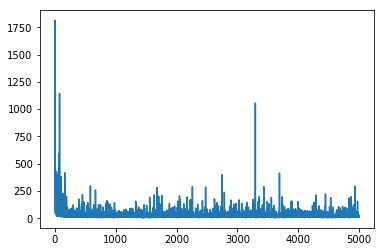

In [18]:
plt.figure()
plt.plot(losses)
plt.show()

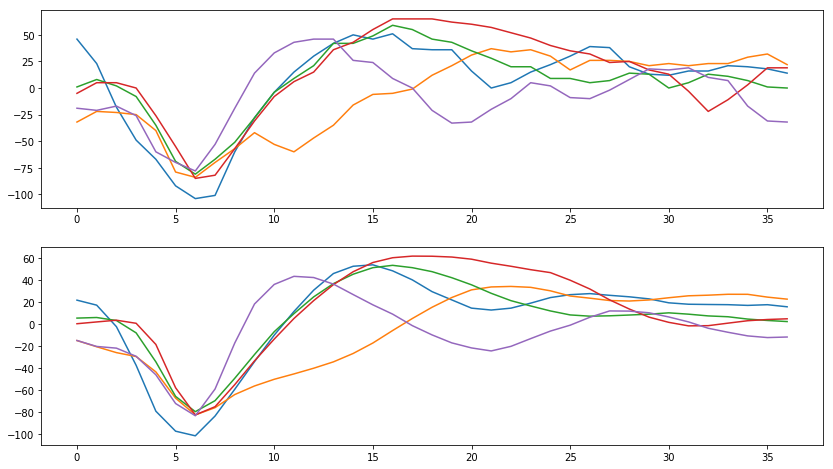

In [19]:
plt.figure(figsize=(14,8))

# n = [1, 30, 45, 50, 65]
n = [3490, 1098, 8707, 6709, 871]


for i in n:
    data = electrode_data_test[i, :]
    data = torch.from_numpy(data).float().cuda()
    enc, o = ae_1.forward(data)
    o = (o.data).cpu().numpy()
    plt.subplot(211)
    plt.plot(electrode_data_test[i, :])
    plt.subplot(212)
    plt.plot(o)
plt.show()

## Using GANs for super-resolution

### Designing the GAN

In [20]:
class generator(nn.Module):
    def __init__(self, input_size, embedding_size):
        super(generator, self).__init__()
        activation_layer = nn.PReLU()
        self.encoder = nn.Sequential(nn.Linear(input_size, 100),
                                     activation_layer,
                                     nn.Linear(100, 50),
                                     activation_layer,
                                     nn.Linear(50, 25),
                                     activation_layer,
                                     nn.Linear(25, 80),
                                     activation_layer,
                                     nn.Linear(80, 28),
                                     activation_layer,
                                     nn.Linear(28, embedding_size))
        self.decoder = nn.Sequential(nn.Linear(embedding_size, 16),
                                     activation_layer,
                                     nn.Linear(16, 25),
                                     activation_layer,
                                     nn.Linear(25, input_size))
    
    def forward(self, x):
        enc = self.encoder(x)
        dec = self.decoder(enc)
        return enc, dec

In [21]:
class discriminator(nn.Module):
    def __init__(self, input_size):
        super(discriminator, self).__init__()
        self.detect = nn.Sequential(nn.Linear(input_size, 32),
                                    nn.ELU(),
                                    nn.Linear(32, 16),
                                    nn.ELU(),
                                    nn.Linear(16, 4),
                                    nn.ELU(),
                                    nn.Linear(4, 1),
                                    nn.Sigmoid())
    def forward(self, x):
        out = self.detect(x)
        return out

In [22]:
def train_gan(disc, gen, input_data, d_criterion, g_criterion, d_optimizer, g_optimizer, epoch_range,  
              batch_size_d, batch_size_g):
    for num_epoch in range(epoch_range):
        d_selected = random.sample(range(0, input_data.shape[0]), batch_size_d)

        for feats in d_selected:
            #---------Training the discriminator on real data------#
            real_data = input_data[feats, :]
            real_data = torch.from_numpy(real_data).float().cuda()
            #---------FORWARD------------#
            real_decision = disc.forward(real_data)
            real_decision = torch.tensor(real_decision).float().cuda()
            real_loss = d_criterion(real_decision, Variable(torch.ones(1)).cuda())
            #---------BACKWARD------------#
            real_loss.backward()
            
            #---------Training the discriminator on fake data------#
            enc, fake_data = gen.forward(real_data)
            fake_data = torch.tensor(fake_data).float().cuda()
            #---------FORWARD------------#
            fake_decision = disc.forward(fake_data)
            fake_decision = torch.tensor(fake_decision).float().cuda()
            fake_loss = d_criterion(fake_decision, Variable(torch.zeros(1)).cuda())
            #---------BACKWARD------------#
            fake_loss.backward()
            
            d_optimizer.zero_grad()            
            d_optimizer.step()
        
        g_selected = random.sample(range(0, input_data.shape[0]), batch_size_g)
        
        for feats in g_selected:
            x = input_data[feats, :]
            x = torch.from_numpy(x).float().cuda()
            #---------FORWARD------------#
            enc, out = gen.forward(x)
            out = torch.tensor(out).float().cuda()
            g_loss = g_criterion(out, x)
            #---------BACKWARD------------#
            g_optimizer.zero_grad()
            g_loss.backward()
            g_optimizer.step()
            
        print('epoch [{}/{}], disc_real_loss:{:.4f}, disc_fake_loss:{:.4f}, gen_loss:{:.4f}'.format(num_epoch + 1, 
                                                    epoch_range, real_loss.data[0], fake_loss.data[0], g_loss.data[0]))
    return out

In [23]:
def init_gan_weights(layer):
    if type(layer) == nn.Linear:
        nn.init.xavier_normal_(layer.weight)

In [27]:
epoch_range = 100
batch_size_d = 150
batch_size_g = 100
g_learning_rate = 0.0001
d_learning_rate = 0.00001

# Defining the models
gen = generator(length, embedding_size).cuda()
disc = discriminator(length).cuda()

# Initialising the weights
gen.apply(init_gan_weights)
disc.apply(init_gan_weights)

# Setting up the loss criteria
g_criterion = nn.MSELoss()
d_criterion = nn.BCELoss()

# Setting up the Optimizer (Using Adam here)
g_optimizer = torch.optim.Adam(
    gen.parameters(), lr=g_learning_rate, weight_decay=0.001)
d_optimizer = torch.optim.Adam(
    disc.parameters(), lr=d_learning_rate, weight_decay=0.001)

out = train_gan(disc, gen, electrode_data_train, d_criterion, g_criterion, 
                             d_optimizer, g_optimizer, epoch_range, batch_size_d, batch_size_g)

epoch [1/100], disc_real_loss:0.0000, disc_fake_loss:3.8888, gen_loss:883.8180
epoch [2/100], disc_real_loss:0.0000, disc_fake_loss:2.3985, gen_loss:307.5352
epoch [3/100], disc_real_loss:0.0000, disc_fake_loss:2.8301, gen_loss:189.7370
epoch [4/100], disc_real_loss:0.0112, disc_fake_loss:2.4890, gen_loss:390.9312
epoch [5/100], disc_real_loss:0.0000, disc_fake_loss:3.1668, gen_loss:325.1811
epoch [6/100], disc_real_loss:0.0002, disc_fake_loss:2.1567, gen_loss:335.5146
epoch [7/100], disc_real_loss:0.0000, disc_fake_loss:7.4133, gen_loss:132.9198
epoch [8/100], disc_real_loss:0.0001, disc_fake_loss:9.6790, gen_loss:239.4424
epoch [9/100], disc_real_loss:0.1166, disc_fake_loss:2.0839, gen_loss:784.0088
epoch [10/100], disc_real_loss:0.0001, disc_fake_loss:6.1953, gen_loss:262.7629
epoch [11/100], disc_real_loss:0.0933, disc_fake_loss:4.0317, gen_loss:223.2910
epoch [12/100], disc_real_loss:0.0001, disc_fake_loss:4.6844, gen_loss:363.2065
epoch [13/100], disc_real_loss:0.0001, disc_fake_

-8.000192642211914
5.648281633853912
-----------------
-11.005064487457275
-64.62752962112427
-----------------
0.8547663688659668
124.48709601163864
-----------------
-5.006402492523193
25.6644726395607
-----------------
0.3426687717437744
-9.601903021335602
-----------------
13.669493913650513
-31.769505977630615
-----------------
-5.721035957336426
48.847743295133114
-----------------


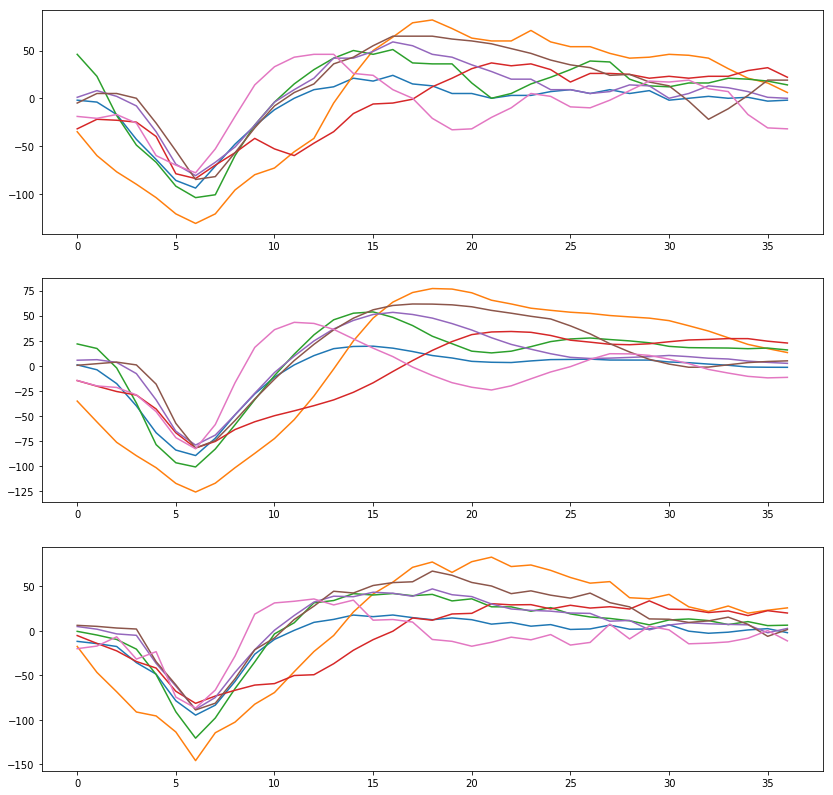

In [25]:
plt.figure(figsize=(14,14))

# n = [1, 30, 45, 50, 65]
n = [11, 290, 3490, 1098, 8707, 6709, 871]


for i in n:
    data = electrode_data_test[i, :]
    data = torch.from_numpy(data).float().cuda()
    enc, o = ae_1.forward(data)
    o = (o.data).cpu().numpy()
    print(np.sum(np.subtract(electrode_data_test[i, :], o)))
    enc, o_gan = gen.forward(data)
    o_gan = (o_gan.data).cpu().numpy()
    print(np.sum(np.subtract(electrode_data_test[i, :], o_gan)))
    print('-----------------')
    plt.subplot(311)
    plt.plot(electrode_data_test[i, :])
    plt.subplot(312)
    plt.plot(o)
    plt.subplot(313)
    plt.plot(o_gan)
plt.show()

In [26]:
#torch.save(model, 'autoencoder_26062018.pt') #Saving the autoencoder model

## Designing VAE for Test